In [2]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(threshold=np.inf)
from matplotlib import gridspec
from glob import glob
from skimage import io
from skimage.segmentation import mark_boundaries
from IPython.display import display
from PIL import Image
from dask import bag, threaded
from dask.diagnostics import ProgressBar

MIN_OBJ_VAL = 1000
EVALUATION_CLASSES = ['car', 'motorbicycle', 'bicycle', 'person', 'truck', 'bus', 'tricycle']
DATA_DIR = './store'
CLASS_DICT = {
    0:'others',
    1:'rover', 
    17:'sky', 
    33:'car', 
    34:'motorbicycle', 
    35:'bicycle', 
    36:'person', 
    37:'rider', 
    38:'truck', 
    39:'bus', 
    40:'tricycle', 
    49:'road', 
    50:'siderwalk', 
    65:'traffic_cone'
}


 
DATA_DIR = './store'
path_dict = dict(path = glob(os.path.join(DATA_DIR, '*', '*.*p*g')))
    
paths_df = pd.DataFrame(path_dict)

paths_df['split'] = paths_df['path'].map(lambda x: x.split('/')[-2].split('_')[0])
paths_df['group'] = paths_df['path'].map(lambda x: x.split('/')[-2].split('_')[-1])
paths_df['group'] = paths_df['group'].map(lambda x: 'color' if x == 'test' else x)
paths_df['id'] = paths_df['path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))

group_df = paths_df.pivot_table(
    values='path', columns='group', aggfunc='first', index=['id', 'split']).reset_index()
train_df = group_df.query('split=="train"')

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


display(group_df.sample(10))

group,id,split,color,label
36739,171206_033933096_Camera_6,train,./store/train_color/171206_033933096_Camera_6.jpg,./store/train_label/171206_033933096_Camera_6_...
31675,171206_032616140_Camera_5,train,./store/train_color/171206_032616140_Camera_5.jpg,./store/train_label/171206_032616140_Camera_5_...
9933,170908_072848782_Camera_5,train,./store/train_color/170908_072848782_Camera_5.jpg,./store/train_label/170908_072848782_Camera_5_...
7238,170908_065621733_Camera_5,train,./store/train_color/170908_065621733_Camera_5.jpg,./store/train_label/170908_065621733_Camera_5_...
31640,171206_032613760_Camera_6,train,./store/train_color/171206_032613760_Camera_6.jpg,./store/train_label/171206_032613760_Camera_6_...
34751,171206_033308552_Camera_5,train,./store/train_color/171206_033308552_Camera_5.jpg,./store/train_label/171206_033308552_Camera_5_...
13691,170908_075326291_Camera_5,train,./store/train_color/170908_075326291_Camera_5.jpg,./store/train_label/170908_075326291_Camera_5_...
4907,170908_065128170_Camera_5,train,./store/train_color/170908_065128170_Camera_5.jpg,./store/train_label/170908_065128170_Camera_5_...
13358,170908_075302125_Camera_5,train,./store/train_color/170908_075302125_Camera_5.jpg,./store/train_label/170908_075302125_Camera_5_...
26471,171206_025800363_Camera_5,train,./store/train_color/171206_025800363_Camera_5.jpg,./store/train_label/171206_025800363_Camera_5_...


(2710, 3384, 3) COLOR SIZE
(2710, 3384) LABEL_SIZE
2710
(2710, 3384, 3) COLOR SIZE
(2710, 3384) LABEL_SIZE
2710


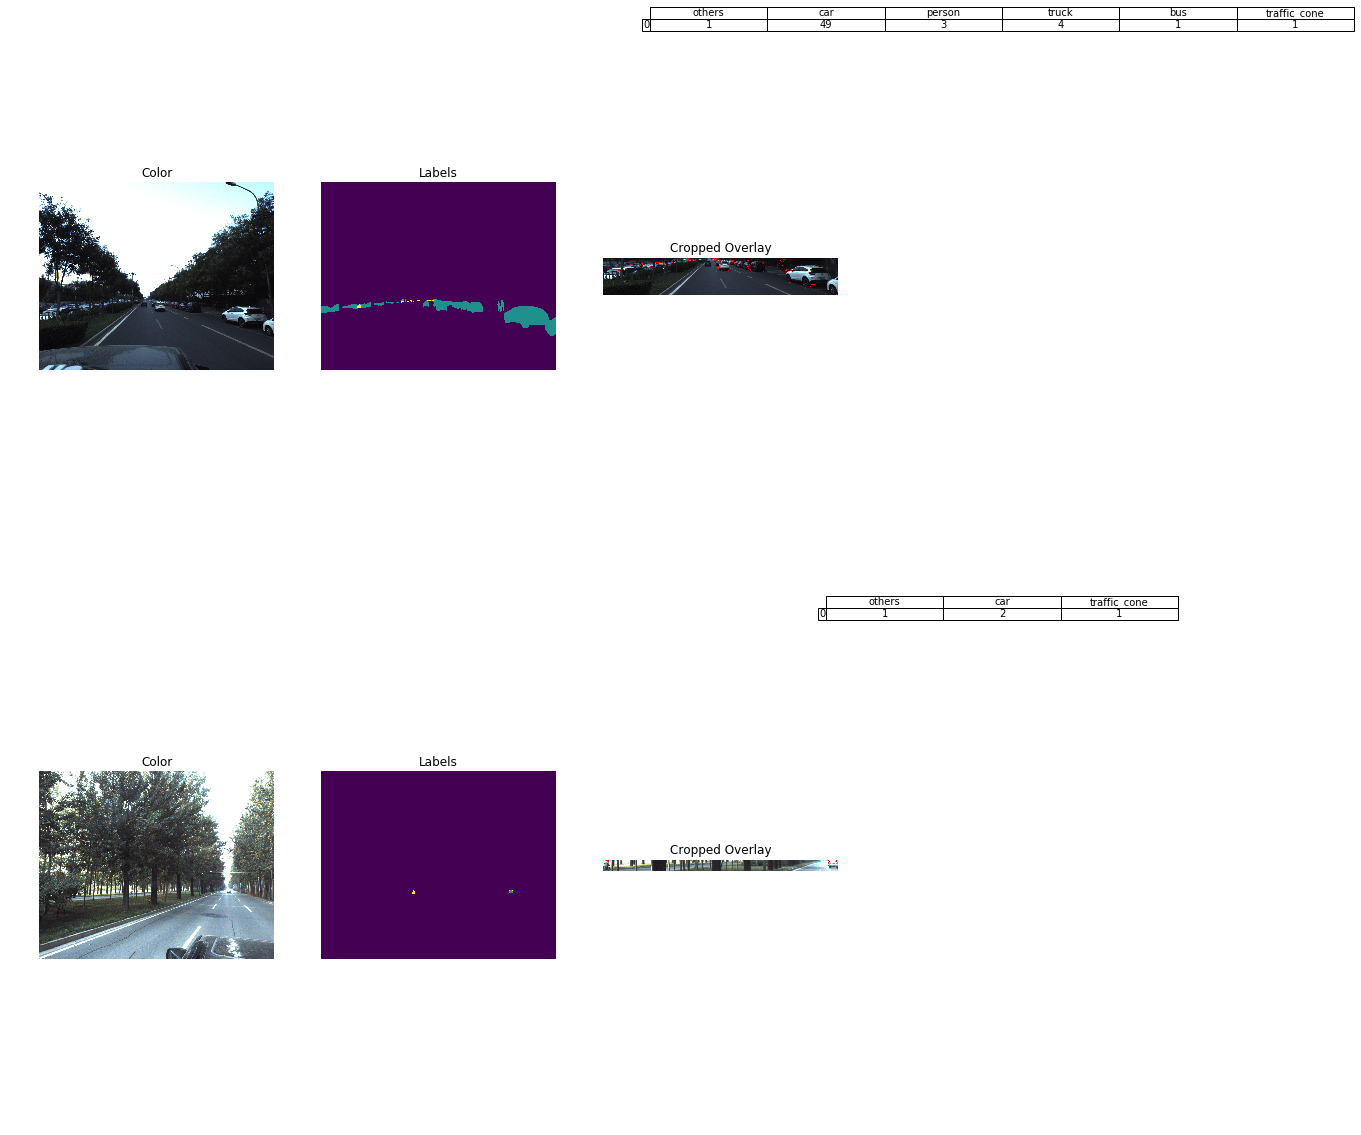

In [17]:
class ImageViewer:
    def __init__(self, nrows, img_df, img_size=20):
        self.nrows=nrows
        self.img_df = img_df
        self.img_size=img_size
        plt.rcParams["figure.figsize"] = [16,9]
        self.fig, self.m_axs = plt.subplots(
            nrows, 4, figsize=(img_size, nrows*6))
        [set_size(15, 15, ax) for ax in self.m_axs.flatten()]
        [c_ax.axis('off') for c_ax in self.m_axs.flatten()]
    
    def render(self):
        
        for (ax1, ax2, ax3, ax4), (_, c_row) in zip(self.m_axs, self.img_df.sample(self.nrows).iterrows()):
            c_img = io.imread(c_row['color'])
            l_img = io.imread(c_row['label'])
            print(c_img.shape, 'COLOR SIZE')
            print(l_img.shape, 'LABEL_SIZE')
            
            if l_img.ndim==3: l_img = l_img[:,:,0]    
            ax1.imshow(c_img)
            ax1.set_title('Color')
            
            #nice_limg = np.zeros(l_img.shape, dtype=np.uint8)
            #for new_idx, old_idx in enumerate(np.unique(l_img[l_img > MIN_OBJ_VAL]), 1):
            #    nice_limg[l_img==old_idx] = new_idx
            
            ax2.imshow(l_img)
            ax2.set_title('Labels')
            xd, yd = np.where(l_img > MIN_OBJ_VAL)
            bound_img = mark_boundaries(image=c_img, label_img=l_img, color=(1,0,0), background_label= 255, mode='thick')
            ax3.imshow(bound_img[xd.min():xd.max(), yd.min(): yd.max(), :])
            ax3.set_title('Cropped Overlay')
            table_args = self.get_img_target_counts(l_img)
            ax4.table(**table_args)

    def get_img_target_counts(self, img):
        tlabel = np.asarray(img, dtype=int)
        print(len(tlabel))
        cls = np.unique(tlabel) // 1000
        unique, counts = np.unique(cls, return_counts = True)
        df = pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index').transpose()
        df.rename(columns=CLASS_DICT, inplace=True)
        return {
            'cellText': df.values,
            'colWidths': [0.5]*len(df.columns),
            'rowLabels': [0],
            'colLabels': df.columns,
            'loc': 'top',
            'cellLoc': 'center',
            'rowLoc': 'center'
        }
nimages = 2
viewer = ImageViewer(nimages, train_df)

viewer.render()

In [ ]:
def load_labels_df():
    labels_df = pd.read_csv('./store/train_labels.csv')
    labels_df = labels_df[EVALUATION_CLASSES]
    return labels_df

labels_df = load_labels_df()
classes_df = pd.melt(labels_df)
groups = classes_df.groupby('variable')
sums = groups.sum()

#print(sums.index)

sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=sums.index, y=sums.value, color='steelblue')
ax.set(xlabel='', ylabel='count')
sns.despine(trim=True)



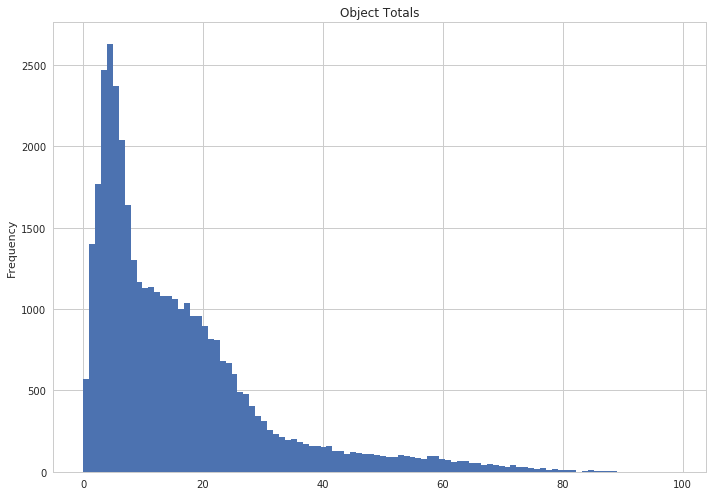

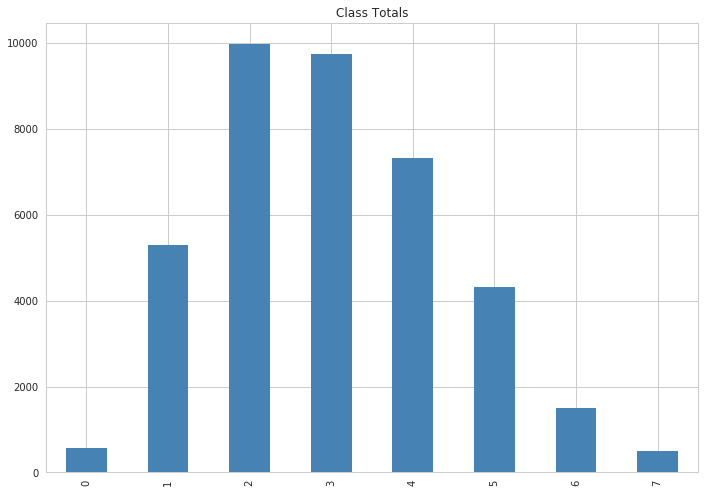

In [82]:
labels_df = load_labels_df()

labels_df['objects'] = labels_df.sum(axis=1)
labels_df['classes'] = labels_df[labels_df > 0].count(axis=1) - 1
labels_df.clip(lower=0, inplace=True)



plt.figure()
plt.title("Object Totals")
labels_df['objects'].plot.hist(bins=100)

plt.figure()
plt.title('Class Totals')
labels_df['classes'].value_counts().sort_index().plot.bar(color='steelblue')



In [86]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

IMG_SIZE = (384, 384)
img_gen_args = dict(
    samplewise_center=False,
    horizontal_flip = True,
    vertical_flip = False,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    rotation_range = 3,
    shear_range = 0.01,
    fill_mode = 'nearest',
    zoom_range = 0.05
)

def flow_from_dataframe(img_data_gen, input_df, path_col, y_col, seed=None, )

rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(**img_gen_args)



ValueError: bad mode 'RGB'